# HPGe simulation 2

In [2]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.signal import peak_widths
import os

In [3]:
#taken from europium gamma decay spectrum, all decay channels with an intensity >0.01%
europium_energy_peaks_ev = [121781.7, 125690, 148010, 212568, 244697.4, 251633, 271131, 275449, 285980, 295938.7, 315174, 324830, 329425, 340400,
                           344278.5, 351660, 367789.1, 411116.5, 416048, 440860, 443965, 482310, 488679.2, 493508, 503474, 511000, 520227, 523130,
                           526881, 534245, 556560, 562930, 563990, 566442, 586265, 656489, 664780, 671155, 674675, 674677, 678623, 686610, 688670,
                           712843, 719349, 727990, 764900, 768944, 778904.5, 794810, 810451, 839360, 841574, 867380, 896580, 901181, 906010, 919337,
                           926317, 930580, 958630, 963390, 964079, 974090, 990190, 1005272, 1084000, 1085337, 1089737, 1109174, 1112076, 1170930,
                           1206110, 1212948, 1249938, 1261343, 1292778, 1299142, 1348100, 1363770, 1408013, 1457643, 1528103]

europium_decay_probabilities_percent = [28.41, 0.019, 0.035, 0.0196, 7.55, 0.0671, 0.078, 0.0323, 0.01, 0.442, 0.0496, 0.0738, 0.129, 0.031, 26.59,
                                        0.014, 0.862, 2.238, 0.109, 0.0133, 0.32, 2.8, 0.0279, 0.4139, 0.0278, 0.1533, 0.054, 0.0536, 0.0113, 0.0129, 
                                        0.0368, 0.0177, 0.038, 0.457, 0.131, 0.462,  0.1437, 0.01, 0.0194, 0.17, 0.0171, 0.47, 0.02, 0.841, 0.0961,
                                        0.268, 0.0106, 0.19, 0.088, 12.97, 0.0263, 0.317, 0.016, 4.243, 0.0669, 0.084, 0.016, 0.429, 0.273, 0.0729,
                                        0.021, 0.1341, 14.5, 0.0138, 0.0315, 0.665, 0.244, 10.13, 1.73, 0.186, 13.41, 0.0365, 0.0135, 1.416, 0.186,
                                        0.0336, 0.104, 1.633, 0.0175, 0.0256, 20.85, 0.498, 0.281]


cobalt_energy_peaks_ev = [347140, 826100, 1173222.8, 1332492, 2158570, 2505692]
cobalt_decay_probabilities_percent = [0.0075, 0.0076, 99.85, 99.9826, 0.0012, 0.000002]

americium_energy_peaks_ev = [26344.6, 32183, 33196.3, 43420, 55560, 59540.9, 98970, 102980]
americium_decay_probabilities_percent = [2.31, 0.0174, 0.1215, 0.0669, 0.0181, 35.92, 0.0203, 0.0195]

def normalise_probabilities(prob_table):
    prob_total = np.sum(np.array(prob_table))
    normalised_prob_table = prob_table / prob_total
    normalised_prob_table = normalised_prob_table.tolist()

    return normalised_prob_table

normalised_europium_decay_probabilities = normalise_probabilities(europium_decay_probabilities_percent)
normalised_cobalt_decay_probabilities = normalise_probabilities(cobalt_decay_probabilities_percent)
normalised_americium_decay_probabilities = normalise_probabilities(americium_decay_probabilities_percent)

decay_energies_array = [europium_energy_peaks_ev, cobalt_energy_peaks_ev, americium_energy_peaks_ev]
decay_probabilities_array = [normalised_europium_decay_probabilities, normalised_cobalt_decay_probabilities, normalised_americium_decay_probabilities]

## Defining the materials

In [4]:
#materials
aluminium_mat = openmc.Material()
aluminium_mat.add_element('Al', 1, percent_type = 'ao')
aluminium_mat.set_density('g/cm3', 2.6989)

beryllium_mat = openmc.Material()
beryllium_mat.add_element('Be', 1, percent_type = 'ao')
beryllium_mat.set_density('g/cm3', 1.848)

carbon_mat = openmc.Material()
carbon_mat.add_element('C', 1, percent_type = 'ao')
carbon_mat.set_density('g/cm3', 2)

copper_mat = openmc.Material()
copper_mat.add_element('Cu', 1, percent_type = 'ao')
copper_mat.set_density('g/cm3', 8.96)

germanium_mat = openmc.Material()
germanium_mat.add_element('Ge', 1, percent_type = 'ao')
germanium_mat.set_density('g/cm3', 5.323)

lead_mat = openmc.Material()
lead_mat.add_element('Pb', 1, percent_type = 'ao')
lead_mat.set_density('g/cm3', 11.35)

mylar_mat = openmc.Material()
mylar_mat.add_element('C', 10, percent_type = 'ao')
mylar_mat.add_element('H', 8, percent_type = 'ao')
mylar_mat.add_element('O', 4, percent_type = 'ao')
mylar_mat.set_density('g/cm3', 1.38)

vacuum_mat = openmc.Material()#setting a vacuum material as air with a near-zero density
vacuum_mat.add_element('C', 0.00015, percent_type = 'ao')
vacuum_mat.add_element('N', 0.784429, percent_type = 'ao')
vacuum_mat.add_element('O', 0.210750, percent_type = 'ao')
vacuum_mat.add_element('Ar', 0.004671, percent_type = 'ao')
vacuum_mat.set_density('g/cm3', 0.001)


materials = openmc.Materials([aluminium_mat, beryllium_mat, copper_mat, germanium_mat, lead_mat, mylar_mat, vacuum_mat])
materials.export_to_xml()

# Defining the geometries

In [10]:
#surfaces

lead_shield_out = openmc.model.RightCircularCylinder([0, 0, -28], 61, 28.5, axis = 'z', boundary_type = 'vacuum')
lead_shield_in = openmc.model.RightCircularCylinder([0, 0, -23], 46, 12.5, axis = 'z', boundary_type = 'vacuum')

outer_cylinder_out = openmc.model.RightCircularCylinder([0, 0, -23], 23, 5, axis = 'z')
outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -23], 22.84, 4.9, axis = 'z')

outer_cylinder_roof = openmc.model.RightCircularCylinder([0, 0, -0.16], 0.16, 5, axis = 'z')

aluminium_case_out = openmc.model.RightCircularCylinder([0, 0, -11.06], 10.494, 4.5, axis = 'z')
aluminium_case_in = openmc.model.RightCircularCylinder([0, 0, -10.76], 10.194, 4.42, axis = 'z')

aluminium_layer = openmc.model.RightCircularCylinder([0, 0, -0.566], 0.003, 4.5, axis = 'z')
mylar_layer = openmc.model.RightCircularCylinder([0, 0, -0.563], 0.003, 4.5, axis = 'z')

germanium_crystal = openmc.model.RightCircularCylinder([0, 0, -6.626], 6.06, 2.855, axis = 'z')
germanium_crystal.id = 1

interior_hole_cylinder = openmc.model.RightCircularCylinder((0, 0, -23), 21.104, 0.48, axis = 'z')
interior_hole_sphere = openmc.Sphere(0, 0, -1.896, 0.48)

Rounded Hole Region: ((-96 97 -98) | -99)
Lead Shield Region: (-66 67 -68 (69 | -70 | 71))
Outer Cylinder Region: (-72 73 -74 (75 | -76 | 77) ~((-96 97 -98) | -99))
Aluminium Case Region: (-81 82 -83 (84 | -85 | 86) ~((-96 97 -98) | -99))
Aluminium Layer Region: (-87 88 -89)
Mylar Layer Region: (-90 91 -92)
Germanium Crystal Region: (-93 94 -95 ~((-96 97 -98) | -99))
Vacuum Region: (-69 70 -71 ~(-72 73 -74 (75 | -76 | 77) ~((-96 97 -98) | -99)) ~(-78 79 -80) ~(-81 82 -83 (84 | -85 | 86) ~((-96 97 -98) | -99)) ~(-87 88 -89) ~(-90 91 -92) ~(-93 94 -95 ~((-96 97 -98) | -99)))


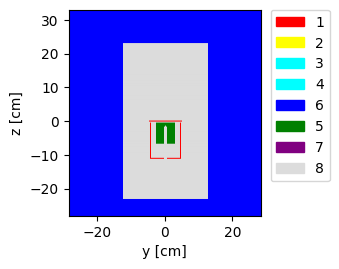

In [11]:
colour_assignment = {aluminium_mat: 'red', beryllium_mat: 'yellow', carbon_mat: 'cyan', copper_mat: 'cyan', lead_mat: 'blue', germanium_mat: 'green', mylar_mat: 'purple',
                    vacuum_mat: 'gainsboro'}

rounded_hole_region = -interior_hole_cylinder | -interior_hole_sphere
print(f"Rounded Hole Region: {rounded_hole_region}")

lead_shield_region = -lead_shield_out & +lead_shield_in
print(f"Lead Shield Region: {lead_shield_region}")
lead_shield_cell = openmc.Cell(region = lead_shield_region)
lead_shield_cell.fill = lead_mat

outer_cylinder_region = -outer_cylinder_out & +outer_cylinder_in & ~rounded_hole_region
print(f"Outer Cylinder Region: {outer_cylinder_region}")
outer_cylinder_cell = openmc.Cell(region = outer_cylinder_region)
outer_cylinder_cell.fill = aluminium_mat

outer_cylinder_roof_region = -outer_cylinder_roof
outer_cylinder_roof_cell = openmc.Cell(region = outer_cylinder_region)
outer_cylinder_roof_cell.fill = carbon_mat

aluminium_case_region = -aluminium_case_out & +aluminium_case_in & ~rounded_hole_region
print(f"Aluminium Case Region: {aluminium_case_region}")
aluminium_case_cell = openmc.Cell(region = aluminium_case_region)
aluminium_case_cell.fill = aluminium_mat

aluminium_layer_region = -aluminium_layer
print(f"Aluminium Layer Region: {aluminium_layer_region}")
aluminium_layer_cell = openmc.Cell(region = aluminium_layer_region)
aluminium_layer_cell.fill = aluminium_mat

mylar_layer_region = -mylar_layer
print(f"Mylar Layer Region: {mylar_layer_region}")
mylar_layer_cell = openmc.Cell(region = mylar_layer_region)
mylar_layer_cell.fill = mylar_mat

germanium_crystal_region = -germanium_crystal & ~rounded_hole_region
print(f"Germanium Crystal Region: {germanium_crystal_region}")
germanium_crystal_cell = openmc.Cell(region = germanium_crystal_region)
germanium_crystal_cell.fill = germanium_mat

vacuum_region = -lead_shield_in & ~outer_cylinder_region & ~outer_cylinder_roof_region & ~aluminium_case_region & ~aluminium_layer_region & ~mylar_layer_region & ~germanium_crystal_region
print(f"Vacuum Region: {vacuum_region}")
vacuum_cell = openmc.Cell(region=vacuum_region)
vacuum_cell.fill = vacuum_mat

geometry = openmc.Geometry([lead_shield_cell, outer_cylinder_cell, aluminium_case_cell, germanium_crystal_cell, aluminium_layer_cell, 
                            mylar_layer_cell, vacuum_cell, outer_cylinder_roof_cell])

plot = geometry.plot(basis = 'yz', color_by = 'material', colors = colour_assignment, legend = True)

geometry.export_to_xml()
